
# Feature transformations with ensembles of trees

### 此Notebook主要是基於，[Facebook發表的廣告點擊預測](http://quinonero.net/Publications/predicting-clicks-facebook.pdf) paper
   - Logistic 使用Tree Based model的**特徵轉換**後的新特徵，表現會優於Tree Based Model。
   - 此Notebook 使用**Holdout Scheme**，避免Overfitting

#### 此筆記本是改版他人的開源
#### 原作者: Tim Head <betatim@gmail.com>


In [1]:
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier,GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

from xgboost.sklearn import XGBClassifier
import xgboost as xgb

In [2]:
X, y = make_classification(n_samples=80000,scale=None)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5) 
# 這裡主要是切出測試集X_test, y_test

X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)

# 為什麼切兩次？
# Ans: HoldOut Scheme。 請記住準則概念，避免overfitting，請不要訓練原本數據後，還拿去預測自己的label。

## 藉由調整幾棵樹，看看最後表現
- 樹超過一定數量表現就會差不多

In [3]:
n_estimator = 100 # 請手動調整看看

### Unsupervised transformation based on totally random trees
`RandomTreesEmbedding`

In [4]:
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator, random_state=1)
rt_lm = LogisticRegression()

pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 隨機森林特徵轉換，使用Logistic

In [5]:
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator, random_state=1) # 隨機森林
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()

rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train)) # 把Tree based轉換後的特徵，進行One Hot，
                              # Why One Hot ?
                              # 請點擊開頭的連結paper，看到 Figure 1 底下文字， 
                              # The output of each individual tree is treated as a ""CATEGORICAL"" input feature 
                              # 這是Tree Based model 不用OneHot 有差嗎？
                              # Reply: please try it.
                              # PS 設定幾棵樹，假設N，他的特徵欄位就有N個，所以這是矩陣不用LabelEncode  

                              

rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)
                             # Why X_train for GBDT But X_train_lr for Logistic ?
                             # 避免 Overfitting，不要訓練自己後，還去預測自己的label。
        
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/jovyan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## GBM特徵轉換，使用Logistic



In [6]:
grd = GradientBoostingClassifier(n_estimators=n_estimator, random_state=1)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()

grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/jovyan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## XGB 特徵轉換，使用Logistic

In [7]:
xgb = XGBClassifier(
    n_estimators=n_estimator,
    learning_rate =0.3, max_depth=3, seed=1)

xgb_enc = OneHotEncoder()
xgb_lm = LogisticRegression()

xgb.fit(X_train, y_train)
xgb_enc.fit(xgb.apply(X_train))
xgb_lm.fit(xgb_enc.transform(xgb.apply(X_train_lr)), y_train_lr)

y_pred_xgb_lm = xgb_lm.predict_proba(
    xgb_enc.transform(xgb.apply(X_test)))[:, 1]
fpr_xgb_lm, tpr_xgb_lm, _ = roc_curve(y_test, y_pred_xgb_lm)

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/jovyan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 隨機森林


In [8]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

## GBM

In [9]:
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

## XGB

In [10]:
y_pred_xgb = xgb.predict_proba(X_test)[:, 1]
fpr_xgb , tpr_xgb , _ = roc_curve(y_test, y_pred_xgb )

## 預期結果
#### 使用logistic 套用在 Tree based model 特徵轉換後新特徵，表現應該要勝過Tree based model
1. GBT + Logistic  應該要贏過 GBT
2. Randomforest + Logistic 應該要贏過 RandomForest
3. Xgboost + Logistic 應該要贏過 Xgboost

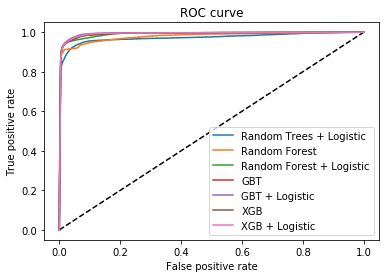

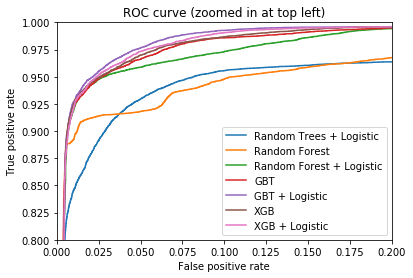

In [11]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='Random Trees + Logistic')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='Random Forest + Logistic')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + Logistic')

plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.plot(fpr_xgb_lm, tpr_xgb_lm, label='XGB + Logistic')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='Random Trees + Logistic')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='Random Forest + Logistic')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + Logistic')

plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.plot(fpr_xgb_lm, tpr_xgb_lm, label='XGB + Logistic')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()